<a href="https://colab.research.google.com/github/ReymonDwiTandiboro/DL_Garbage/blob/main/bentukroti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
dataset_path = Path('/kaggle/input/bentuk-roti/datarot')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [ ]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/kaggle/input/bentuk-roti/datarot/bulat/IMG202...,bulat
1,/kaggle/input/bentuk-roti/datarot/bulat/IMG202...,bulat
2,/kaggle/input/bentuk-roti/datarot/bulat/IMG202...,bulat
3,/kaggle/input/bentuk-roti/datarot/bulat/IMG202...,bulat
4,/kaggle/input/bentuk-roti/datarot/bulat/IMG202...,bulat


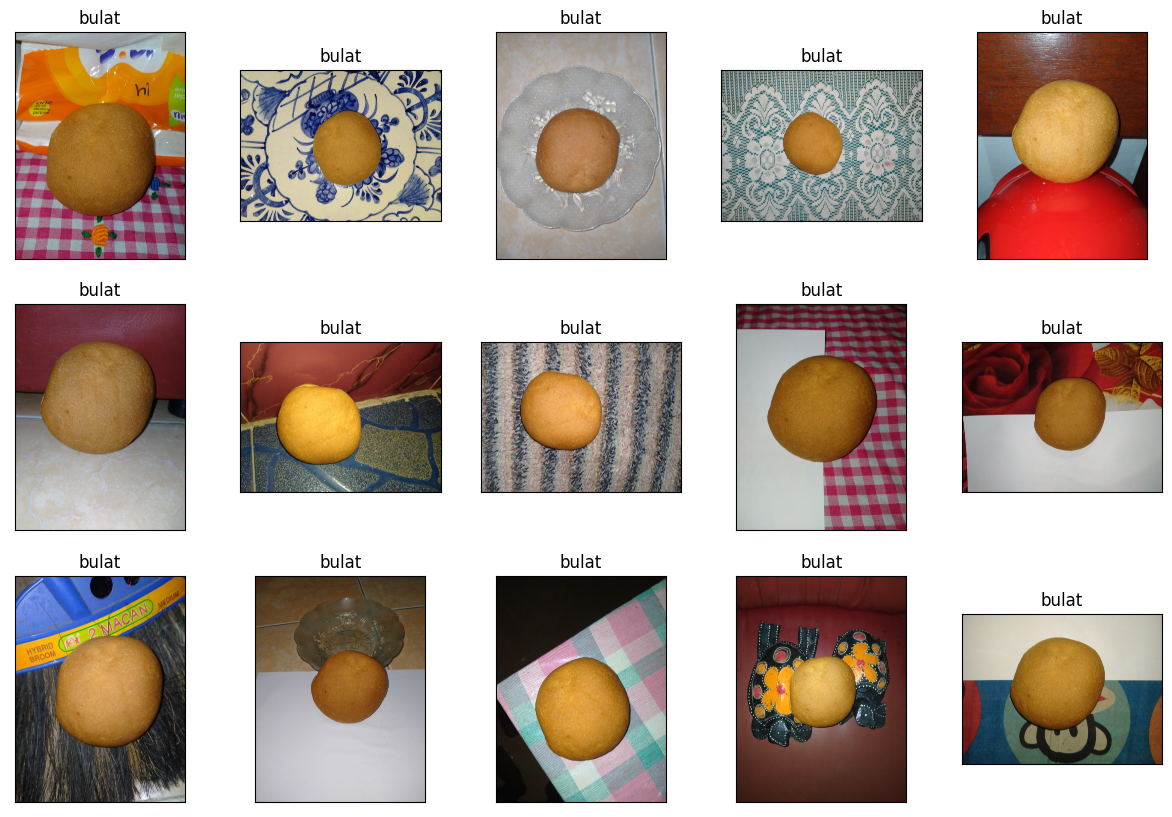

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [ ]:
df.label.value_counts()

bulat              100
persegi panjang    100
persegi            100
Name: label, dtype: int64

In [ ]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

bulat              100
persegi panjang    100
persegi            100
Name: label, dtype: int64

In [ ]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [ ]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (168, 2)
Shape of test data (90, 2)
Shape of validation data (42, 2)


In [ ]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)

Found 168 validated image filenames belonging to 3 classes.
Found 90 validated image filenames belonging to 3 classes.
Found 42 validated image filenames belonging to 3 classes.


In [ ]:
input_shape = (200, 200, 3)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 99, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 32)       0

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 256, validation_data=val, epochs=50, callbacks=callback)

Epoch 1/50
6/6 [==============================] - 25s 4s/step - loss: 0.7746 - accuracy: 0.7143 - val_loss: 0.8937 - val_accuracy: 0.5952
Epoch 2/50
6/6 [==============================] - 19s 3s/step - loss: 0.5911 - accuracy: 0.7738 - val_loss: 0.9269 - val_accuracy: 0.6190
Epoch 3/50
6/6 [==============================] - 21s 4s/step - loss: 0.5830 - accuracy: 0.7202 - val_loss: 1.0265 - val_accuracy: 0.5714
Epoch 4/50
6/6 [==============================] - 19s 3s/step - loss: 0.5668 - accuracy: 0.7500 - val_loss: 1.0233 - val_accuracy: 0.6429
Epoch 5/50
6/6 [==============================] - 19s 3s/step - loss: 0.5305 - accuracy: 0.7500 - val_loss: 0.9400 - val_accuracy: 0.5952
Epoch 6/50
6/6 [==============================] - 19s 3s/step - loss: 0.5614 - accuracy: 0.7917 - val_loss: 1.0363 - val_accuracy: 0.6667
Epoch 7/50
6/6 [==============================] - 19s 4s/step - loss: 0.4061 - accuracy: 0.8452 - val_loss: 0.7926 - val_accuracy: 0.6667
Epoch 8/50
6/6 [==================

In [ ]:
model.save('model-1.h5')

In [ ]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

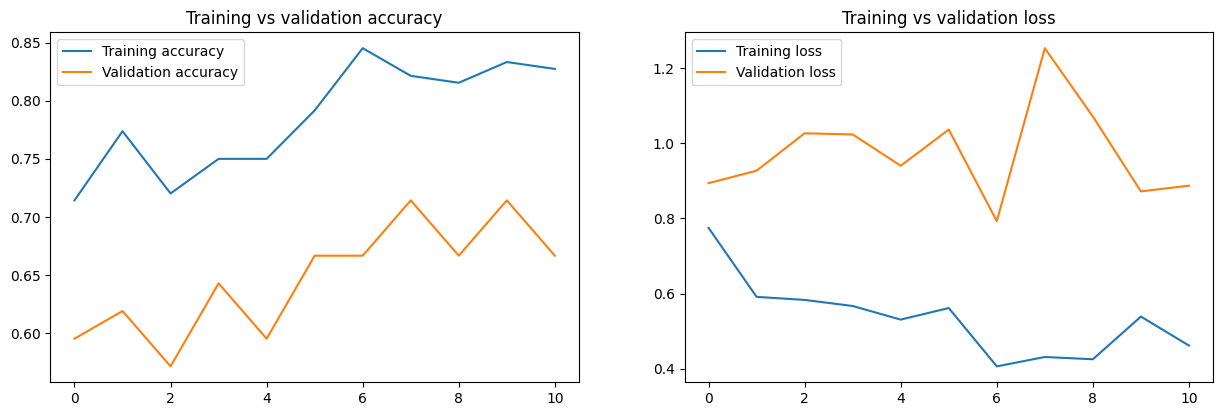

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [ ]:
pred = model.predict(test)

3/3 [==============================] - 8s 3s/step


In [ ]:
pred = np.argmax(pred, axis=1)

In [ ]:
labels = train.class_indices

In [ ]:
labels

{'bulat': 0, 'persegi': 1, 'persegi panjang': 2}

In [ ]:
labels = dict((v,k) for k, v in labels.items())

In [ ]:
labels

{0: 'bulat', 1: 'persegi', 2: 'persegi panjang'}

In [ ]:
y_pred = [labels[k] for k in pred]

In [ ]:
print(classification_report(x_test.label, y_pred))

                 precision    recall  f1-score   support

          bulat       0.51      0.64      0.57        33
        persegi       0.64      0.88      0.74        24
persegi panjang       0.69      0.33      0.45        33

       accuracy                           0.59        90
      macro avg       0.61      0.61      0.58        90
   weighted avg       0.61      0.59      0.57        90



In [ ]:
print(confusion_matrix(x_test.label, y_pred))

[[21  7  5]
 [ 3 21  0]
 [17  5 11]]


In [ ]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 8s 3s/step - loss: 0.7662 - accuracy: 0.6444
